In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:14336'

In [3]:
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', target_types='segmentation', download=True)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting /home/jupyter/mnt/datasets/pets/oxford-iiit-pet/images.tar.gz to /home/jupyter/mnt/datasets/pets/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting /home/jupyter/mnt/datasets/pets/oxford-iiit-pet/annotations.tar.gz to /home/jupyter/mnt/datasets/pets/oxford-iiit-pet


In [4]:
transform = T.Compose(
[
T.Resize((256, 256)),
T.ToTensor(),
]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)


train_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [7]:
from typing import Tuple
@torch.inference_mode()
def evaluate(model, loader) -> Tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [8]:
from typing import List
from IPython.display import clear_output


def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    train_accuracy: List[float],
    valid_accuracy: List[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [9]:
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [10]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))
        if (valid_accuracy >= 0.88):
          break

In [11]:
import torch.nn as nn

def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 24

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4) 
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8) 
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16)
        self.down6 = conv_plus_conv(base_channels * 16, base_channels * 32)
        self.down7 = conv_plus_conv(base_channels * 32, base_channels * 64)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4)
        self.up5 = conv_plus_conv(base_channels * 32, base_channels * 8)
        self.up6 = conv_plus_conv(base_channels * 64, base_channels * 16)
        self.up7 = conv_plus_conv(base_channels * 128, base_channels * 32)

        self.bottleneck = conv_plus_conv(base_channels * 64, base_channels * 64) 

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, base_channels)
        x = self.downsample(residual1)  # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)

        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)
        
        residual3 = self.down3(x)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 4, N // 4, base_channels * 4)
        x = self.downsample(residual3)  # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 8, N // 8, base_channels * 4)

        residual4 = self.down4(x)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 8, N // 8, base_channels * 8)
        x = self.downsample(residual4)  # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 16, N // 16, base_channels * 8)
        
        residual5 = self.down5(x)  # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 16, N // 16, base_channels * 16)
        x = self.downsample(residual5)  # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 32, N // 32, base_channels * 16)
        
        residual6 = self.down6(x)  # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 32, N // 32, base_channels * 32)
        x = self.downsample(residual6)  # x.shape: (N // 32, N // 32, base_channels * 32) -> (N // 64, N // 64, base_channels * 32)
        
        residual7 = self.down7(x)  # x.shape: (N // 64, N // 64, base_channels * 32) -> (N // 64, N // 64, base_channels * 64)
        x = self.downsample(residual7)  # x.shape: (N // 64, N // 64, base_channels * 64) -> (N // 128, N // 128, base_channels * 64)
        
        # LATENT SPACE DIMENSION DIM = N // 128
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 128, N // 128, base_channels * 64) -> (N // 128, N // 128, base_channels * 64)
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 128
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 128, N // 128, base_channels * 64) -> (N // 64, N // 64, base_channels * 64)
        x = torch.cat((x, residual7), dim=1)  # x.shape: (N // 64, N // 64, base_channels * 64) -> (N // 64, N // 64, base_channels * 128)
        x = self.up7(x)  # x.shape: (N // 64, N // 64, base_channels * 128) -> (N // 64, N // 64, base_channels * 32)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 64, N // 64, base_channels * 32) -> (N // 32, N // 32, base_channels * 32)
        x = torch.cat((x, residual6), dim=1)  # x.shape: (N // 32, N // 32, base_channels * 32) -> (N // 32, N // 32, base_channels * 64)
        x = self.up6(x)  # x.shape: (N // 32, N // 32, base_channels * 64) -> (N // 32, N // 32, base_channels * 16)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 16, N // 16, base_channels * 16)
        x = torch.cat((x, residual5), dim=1)  # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 16, N // 16, base_channels * 32)
        x = self.up5(x)  # x.shape: (N // 16, N // 16, base_channels * 32) -> (N // 16, N // 16, base_channels * 8)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 8, N // 8, base_channels * 8)
        x = torch.cat((x, residual4), dim=1)  # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 8, N // 8, base_channels * 16)
        x = self.up4(x)  # x.shape: (N // 8, N // 8, base_channels * 16) -> (N // 8, N // 8, base_channels * 4)
        
        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 4, N // 4, base_channels * 4)
        x = torch.cat((x, residual3), dim=1)  # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 4, N // 4, base_channels * 8)
        x = self.up3(x)  # x.shape: (N // 4, N // 4, base_channels * 8) -> (N // 4, N // 4, base_channels * 2)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 2, N // 2, base_channels * 2)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 2, N // 2, base_channels * 4)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, base_channels * 4) -> (N // 2, N // 2, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N, N, base_channels)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)

        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

In [12]:
import torch.nn as nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla T4


In [13]:
from torch.optim import Adam

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=3e-4)

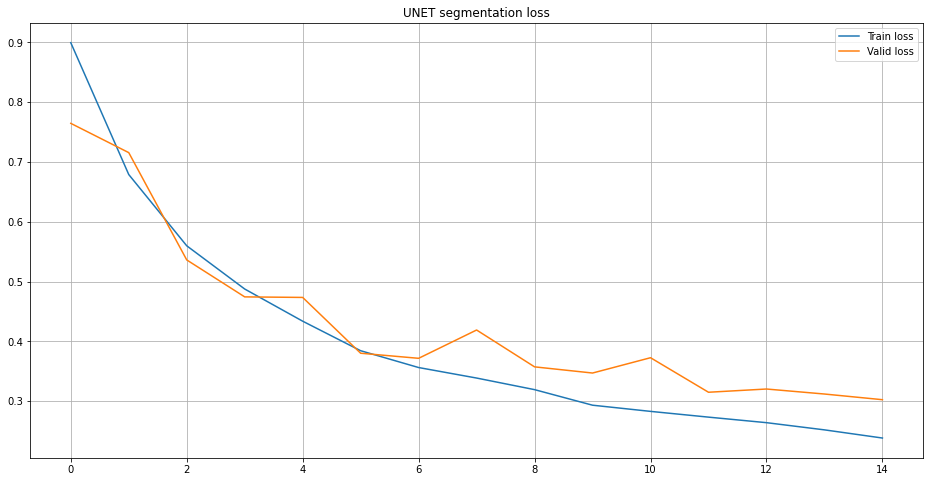

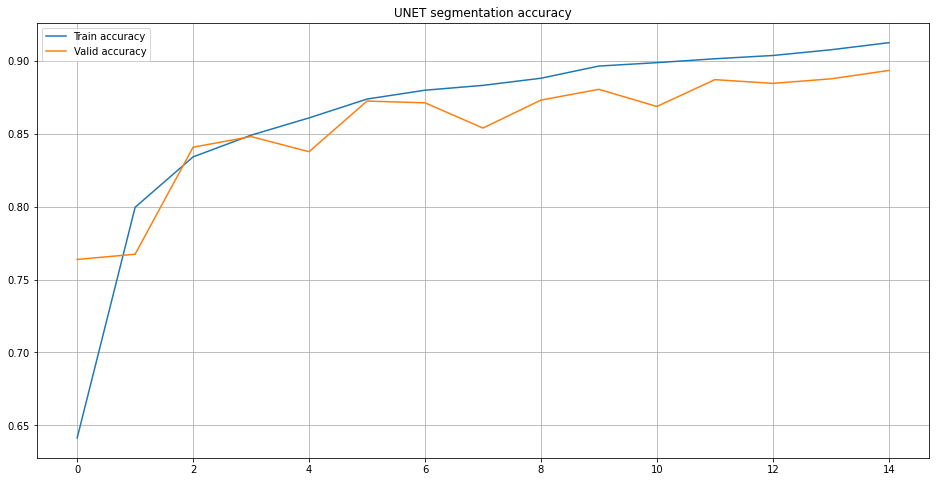

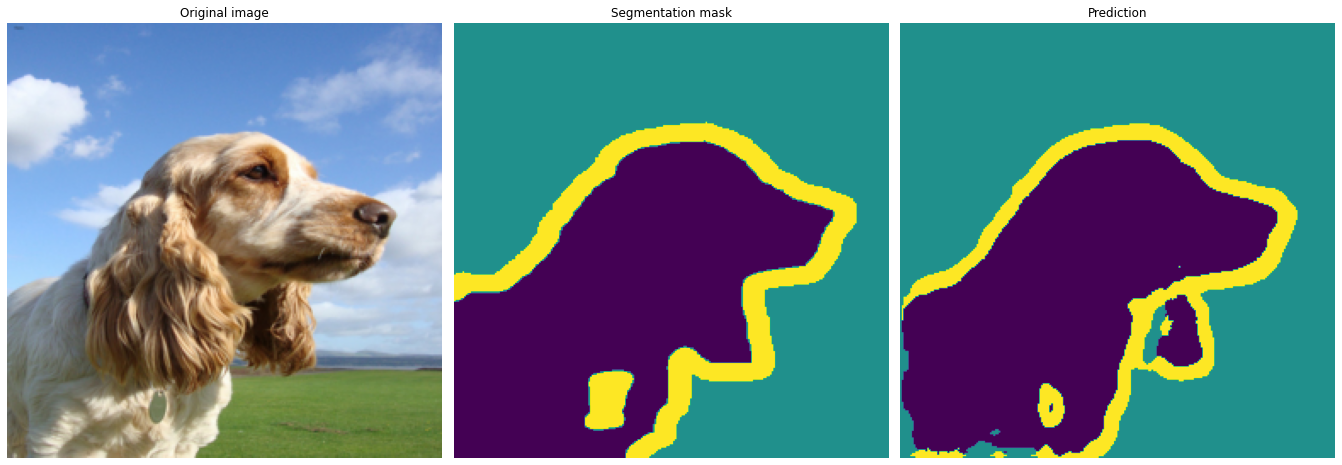

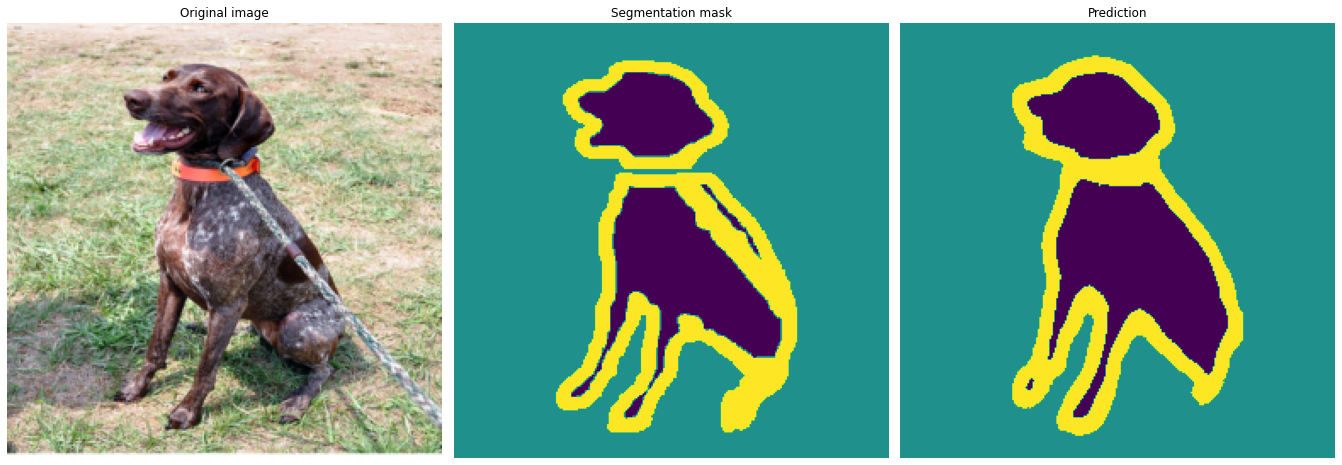

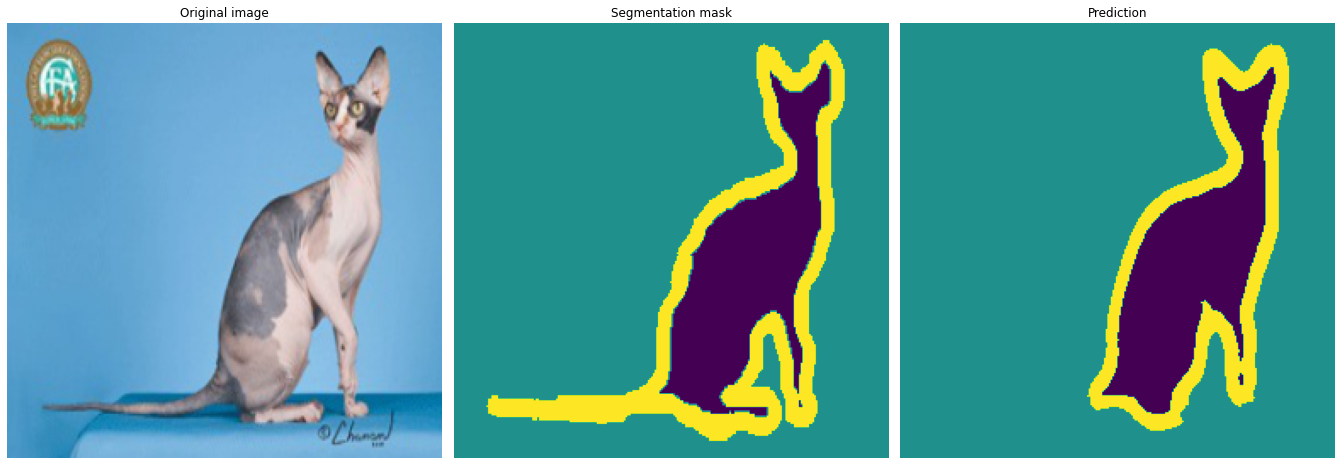

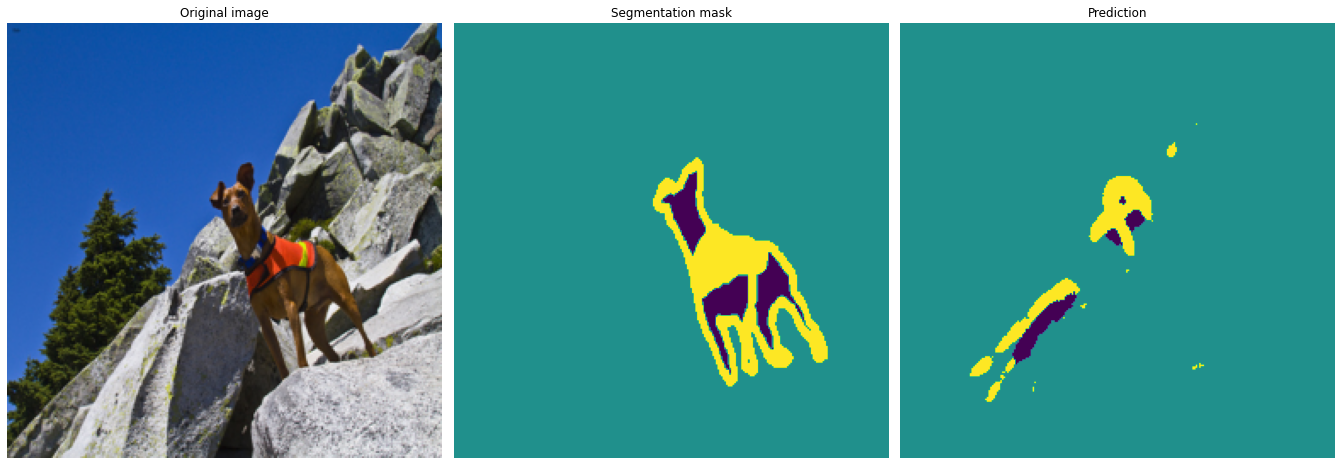

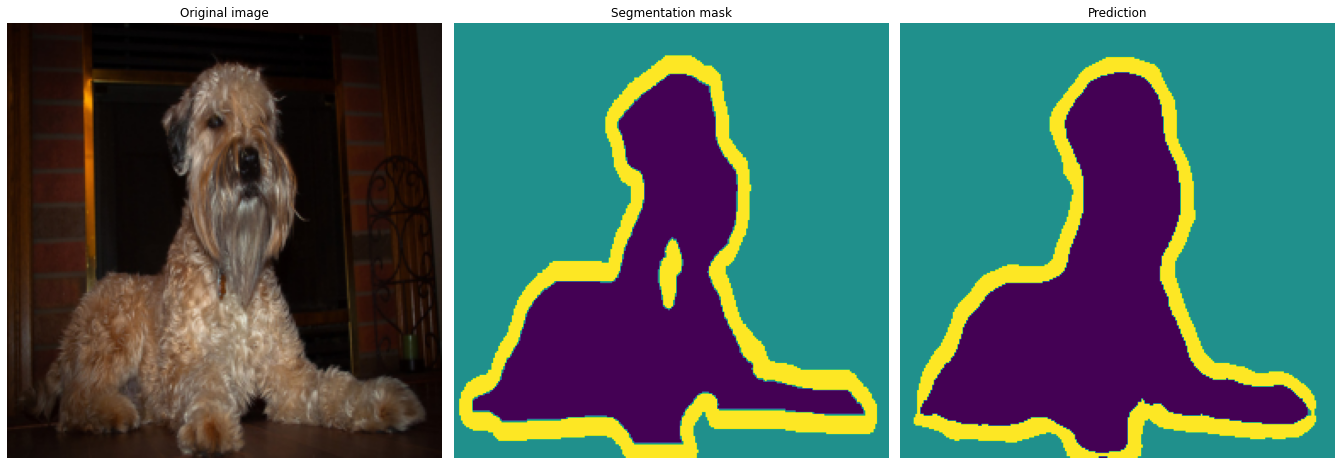

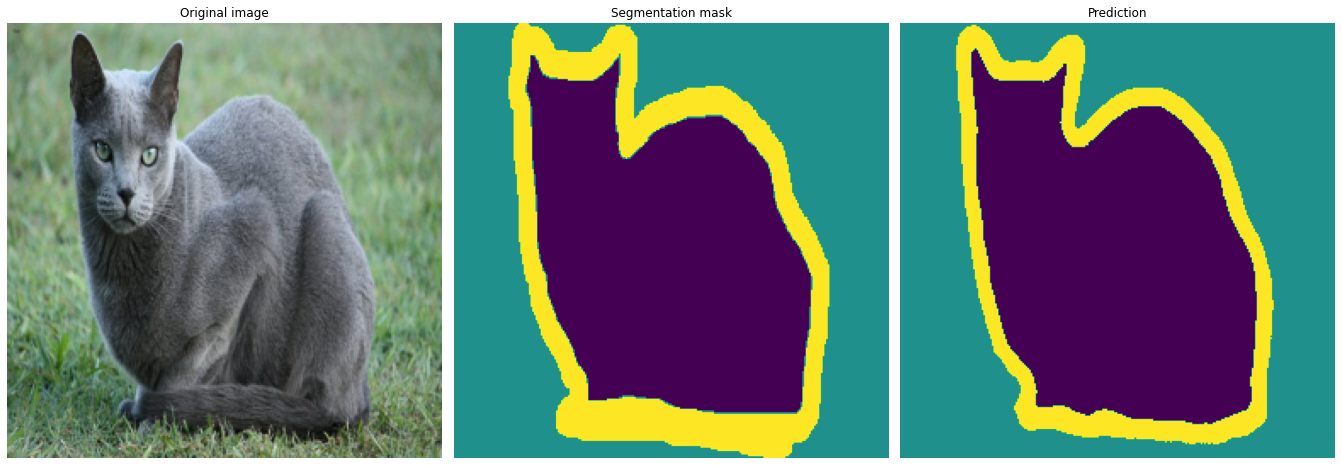

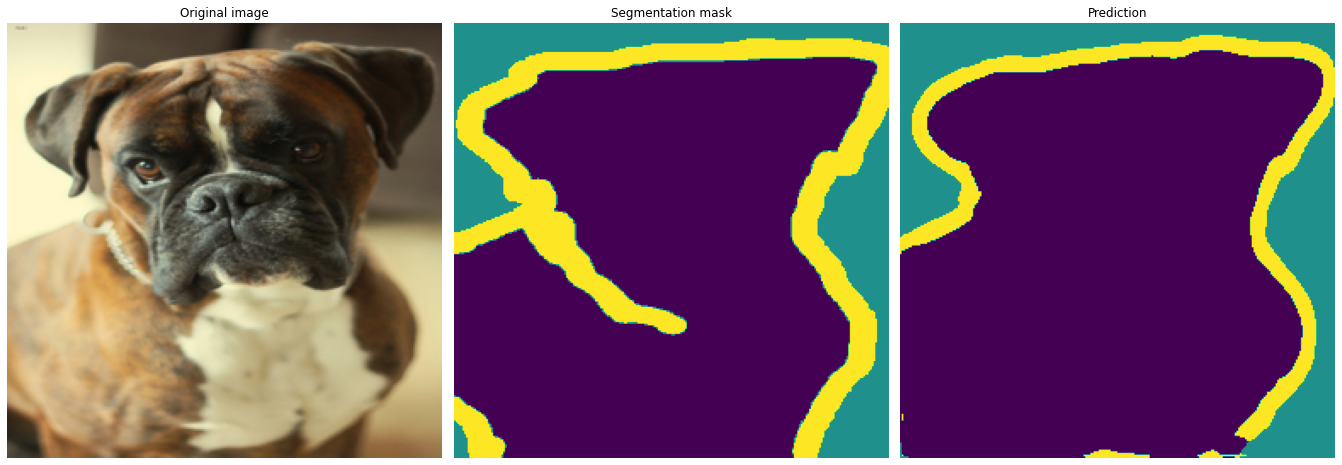

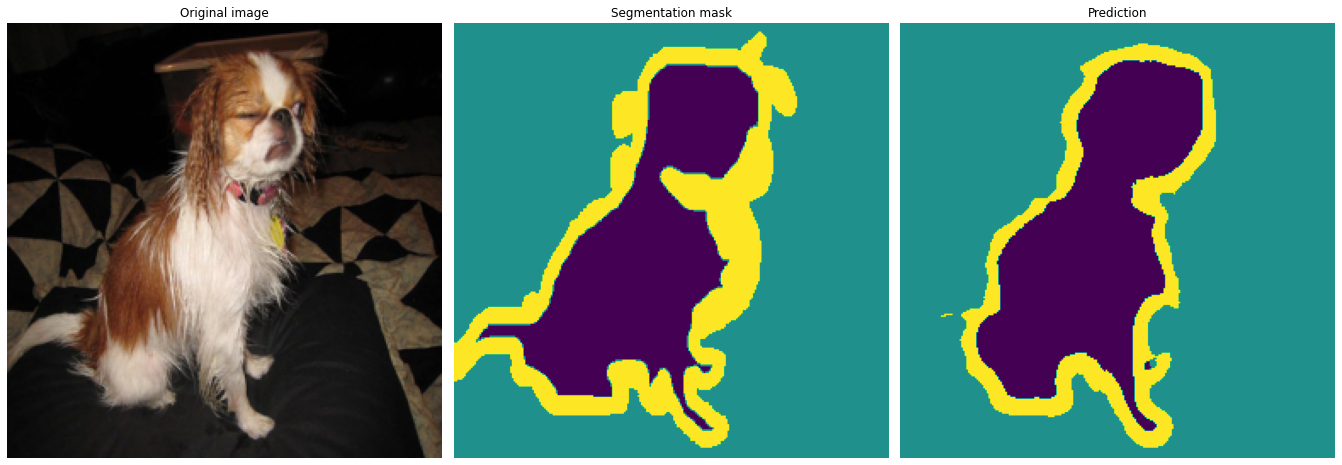

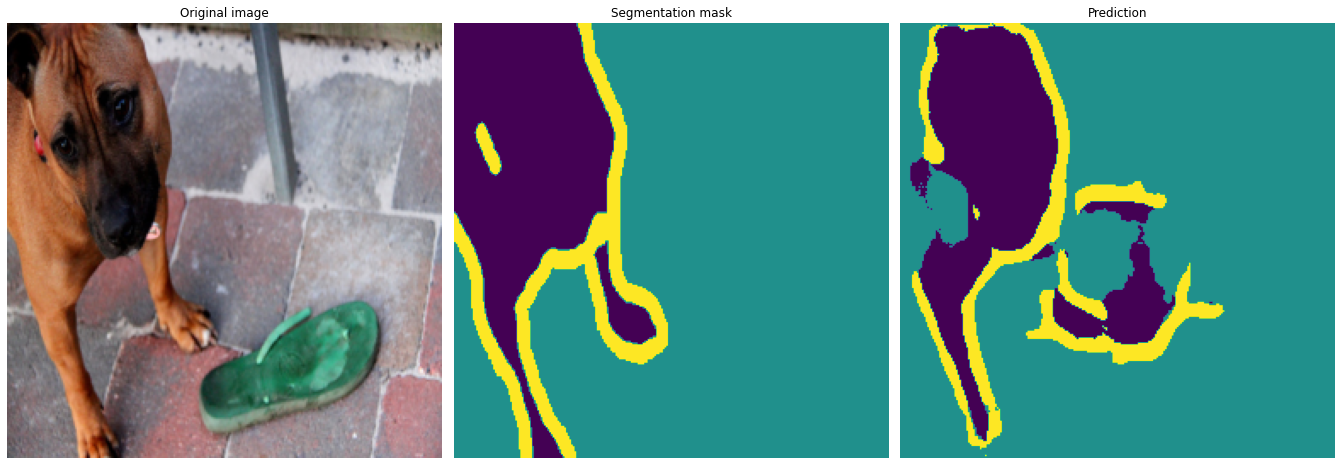

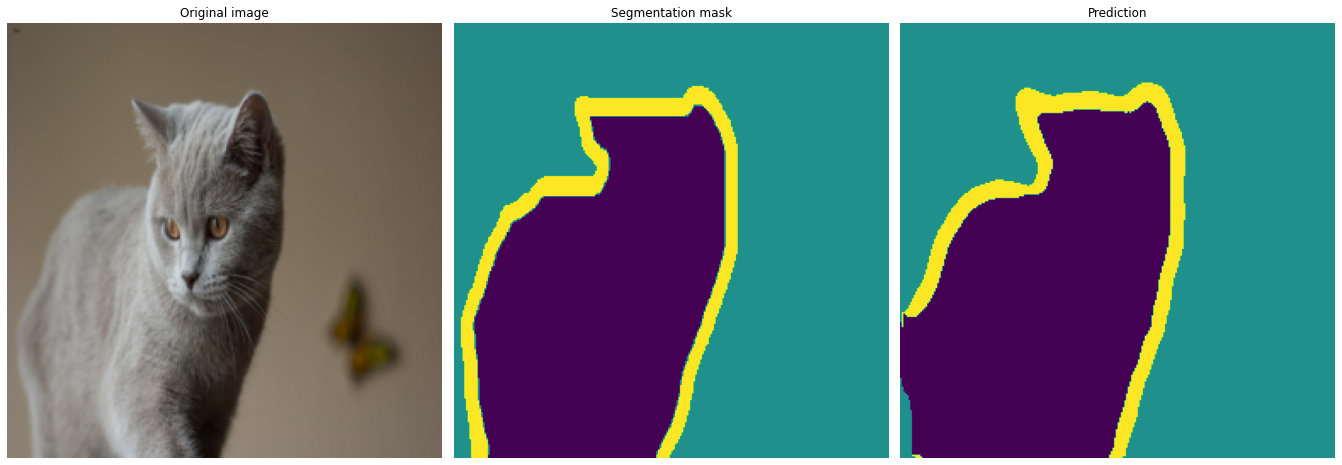

In [14]:
whole_train_valid_cycle(model, 15, 'UNET segmentation')